In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [3]:
df = pd.read_csv(f'{DIR_INPUT}/train.csv')
df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x : np.fromstring(x[1:-1], sep=',', dtype=float)))
df.drop(columns=['bbox'], inplace=True)
df.head(3)

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0


## 数据集合划分

这里我们按照训练集和验证集 `8:2`的比例划分

In [4]:
image_ids = df['image_id'].unique()
train_size = 0.8
split_len = round(len(image_ids)*train_size)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = df[df['image_id'].isin(train_ids)]
valid = df[df['image_id'].isin(valid_ids)]
train.shape, valid.shape

((122577, 8), (25216, 8))

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

## 构建dataset

In [6]:
import cv2 as cv
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
class Wheat(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x', 'y', 'w', 'h']].values
        
        area = boxes[:, 2] * boxes[:, 3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels,
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'])
        return image, target, image_id
        
    def __len__(self):
        return len(self.image_ids)
    
    @staticmethod
    def get_train_transform():
        return A.Compose([
            A.Flip(0.5),
            ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    @staticmethod
    def get_valid_transform():
        return A.Compose([
            ToTensorV2(p=0.1)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
        

In [8]:
train_dataset = Wheat(train, DIR_TRAIN, Wheat.get_train_transform())
valid_dataset = Wheat(valid, DIR_TRAIN, Wheat.get_valid_transform())

## 模型搭建

---
> 这里我选择`fasterrcnn_mobilenetV2_fpn`

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn

model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 128MB/s]


In [10]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [11]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
FastRCNNPredictor(in_features, num_classes)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

## 模型训练

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

超参数设定

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None
num_epochs = 20

In [14]:
import time
from tqdm.notebook import tqdm as tqdm

itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0

for epoch in range(num_epochs):

    start_time = time.time()

    model.train()
    train_loss = []
  
    pbar = tqdm(train_data_loader, desc='let\'s train')
    for images, targets, image_ids in pbar:
    
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses_value = losses.item()
        train_loss.append(losses_value)   

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
        itr += 1
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)

  # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()


    with torch.no_grad():
        valid_loss = []

    for images, targets, image_ids in valid_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        valid_loss.append(loss_value)
        
    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)    
  

    print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 1/20, Time: 231.77856492996216, Train Loss: 1.3571566860979105, Valid Loss: 1.27230424481058


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 2/20, Time: 202.7734088897705, Train Loss: 1.3204988037192351, Valid Loss: 1.2638102439658587


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 3/20, Time: 201.47600722312927, Train Loss: 1.3062715272147116, Valid Loss: 1.2543784495643575


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 4/20, Time: 201.7697458267212, Train Loss: 1.299395998063521, Valid Loss: 1.2340536489046305


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 5/20, Time: 201.79484701156616, Train Loss: 1.2940819151101226, Valid Loss: 1.2397581892976464


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 6/20, Time: 201.66565108299255, Train Loss: 1.287895776468423, Valid Loss: 1.2394472579892155


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 7/20, Time: 200.57312726974487, Train Loss: 1.2794651507972703, Valid Loss: 1.2207183204393164


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 8/20, Time: 201.8906888961792, Train Loss: 1.2707693932496589, Valid Loss: 1.2212399190344287


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 9/20, Time: 200.8766632080078, Train Loss: 1.2659409716131322, Valid Loss: 1.2116278899081794


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 10/20, Time: 199.40207624435425, Train Loss: 1.2643852528251662, Valid Loss: 1.2010787659381275


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 11/20, Time: 201.70170378684998, Train Loss: 1.257826168963927, Valid Loss: 1.2015202930288265


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 12/20, Time: 200.65576720237732, Train Loss: 1.2618987591946274, Valid Loss: 1.2049022434298833


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 13/20, Time: 201.23858284950256, Train Loss: 1.2554347551576646, Valid Loss: 1.1875432873575376


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 14/20, Time: 201.9299032688141, Train Loss: 1.2499034647415526, Valid Loss: 1.1851522785193804


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 15/20, Time: 202.28673243522644, Train Loss: 1.2466361000659054, Valid Loss: 1.1984884803976916


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 16/20, Time: 201.4048843383789, Train Loss: 1.244787208446848, Valid Loss: 1.1998052071489855


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 17/20, Time: 200.07658863067627, Train Loss: 1.2423930326661763, Valid Loss: 1.2545661946118882


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 18/20, Time: 199.8694360256195, Train Loss: 1.238385550514201, Valid Loss: 1.1797835777600552


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 19/20, Time: 199.72198748588562, Train Loss: 1.238644687326034, Valid Loss: 1.1570531171437055


let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 20/20, Time: 199.90592288970947, Train Loss: 1.2311737850576006, Valid Loss: 1.1678053554215857


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

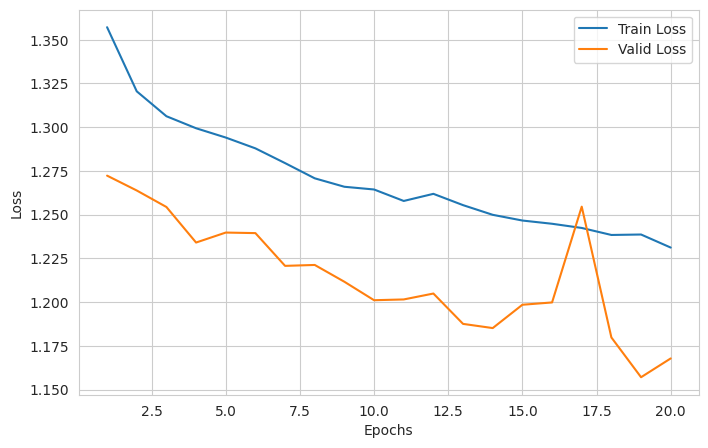

In [15]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
torch.save(model, 'fasterrcnn_mobileNetV3_fpn.pth')